In [1]:
# run initial imports
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from scipy.integrate import odeint
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from mpl_toolkits.basemap import Basemap
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics 

from fbprophet import Prophet

from ipywidgets import widgets

from fbprophet.plot import plot_plotly
import plotly.offline as py

from datetime import datetime

In [2]:
NOW = datetime.now()

In [3]:
#setup initial data frames
input_dir = "./data/"
covid_19_ts = pd.read_csv(input_dir + 'covid_19_ts.csv')
covid_19_national_observations = pd.read_csv(input_dir + 'global/covid_19_national_observations.csv')
covid_19_infected_observations = pd.read_csv(input_dir + 'global/covid_19_infected_observations.csv')
covid_19_world_totals = pd.read_csv(input_dir + 'global/covid_19_world_totals.csv')

In [4]:
#correct date parsing on some of the JH data
covid_19_ts['Date'] = pd.to_datetime(covid_19_ts['Date'])
covid_19_national_observations['Date'] = pd.to_datetime(covid_19_national_observations['Date'])
covid_19_infected_observations['Date'] = pd.to_datetime(covid_19_infected_observations['Date'])
covid_19_world_totals['Date'] = pd.to_datetime(covid_19_world_totals['Date'])

In [5]:
#covid_19_infected_observations = covid_19_infected_observations.sort_values(['Country/Region', 'Day'])
#covid_19_national_observations = covid_19_national_observations.sort_values(['Country/Region', 'Date'])

In [6]:
#quick national overview

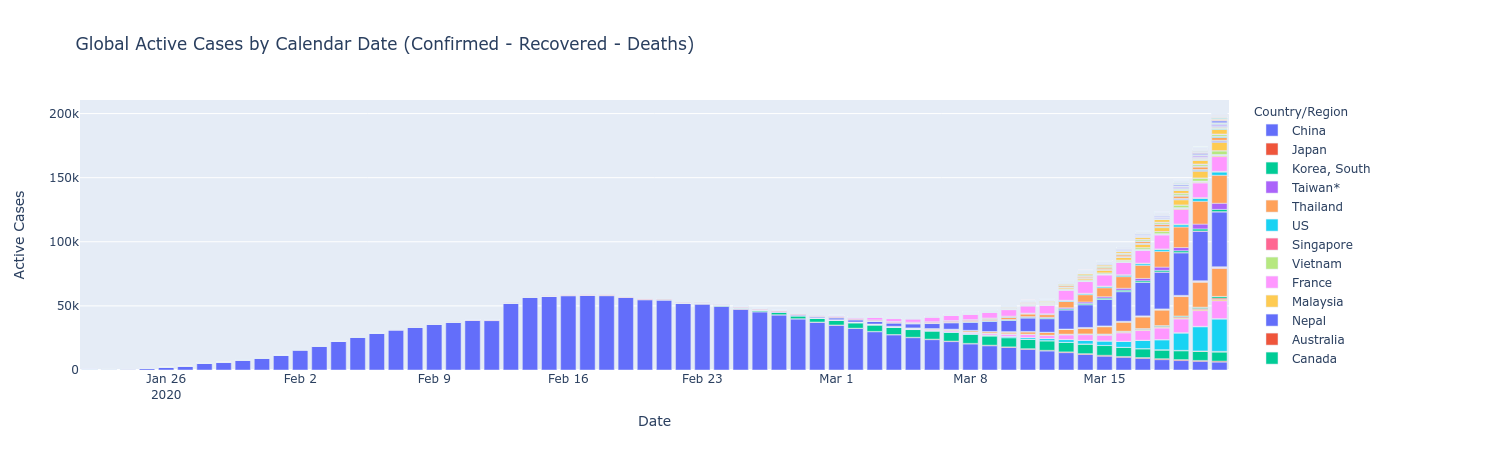

In [7]:
world_chart = px.bar(covid_19_national_observations, 
    x="Date", y="Active Cases", color="Country/Region", title="Global Active Cases by Calendar Date (Confirmed - Recovered - Deaths)")
world_chart.show()

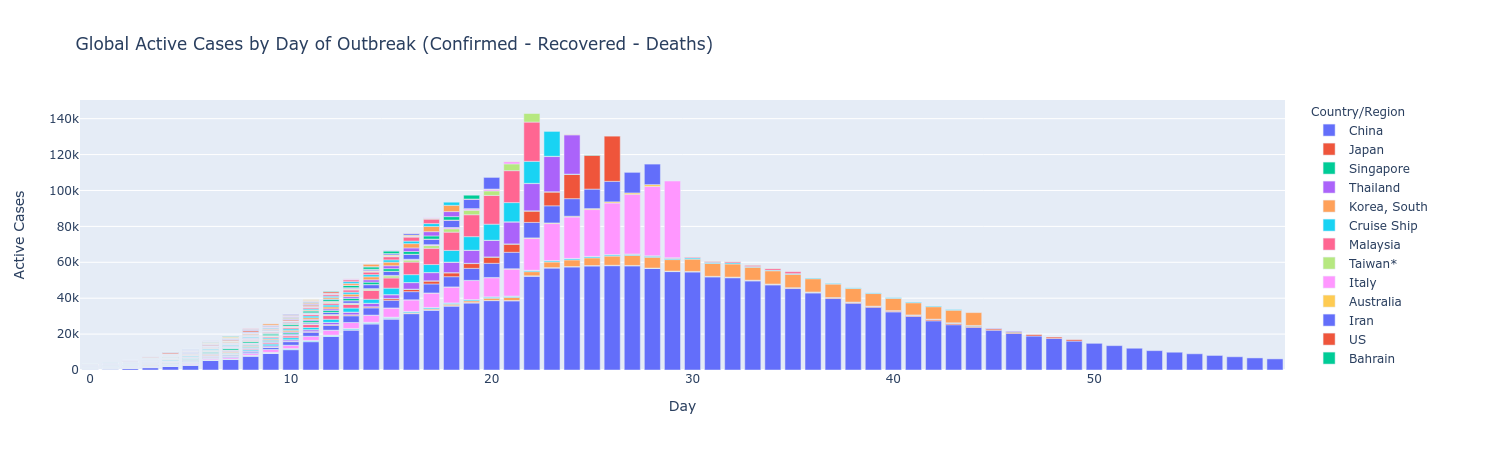

In [8]:
world_chart = px.bar(covid_19_infected_observations, 
    x="Day", y="Active Cases", color="Country/Region", title="Global Active Cases by Day of Outbreak (Confirmed - Recovered - Deaths)")
world_chart.show()

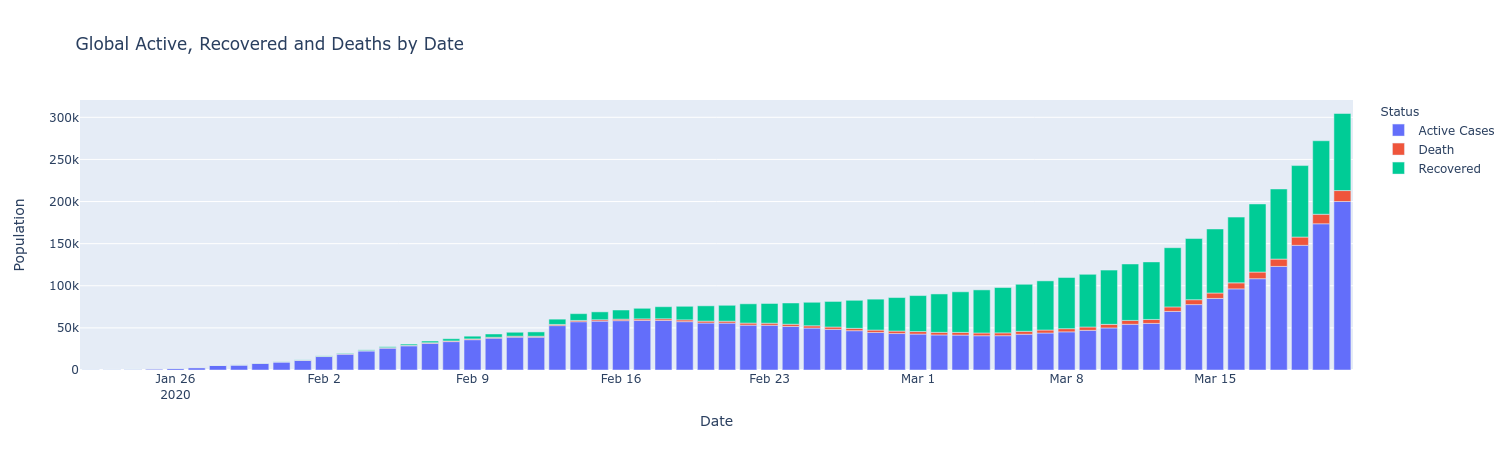

In [29]:
covid_19_world_totals_state = covid_19_world_totals[['Date', 'Active Cases', 'Recovered', 'Death']].melt(id_vars=['Date'], 
            value_vars=['Active Cases', 'Death', 'Recovered'], value_name="Population", var_name='Status')
world_chart = px.bar(covid_19_world_totals_state, 
    x="Date", y="Population", color="Status", title="Global Active, Recovered and Deaths by Date")
world_chart.show()

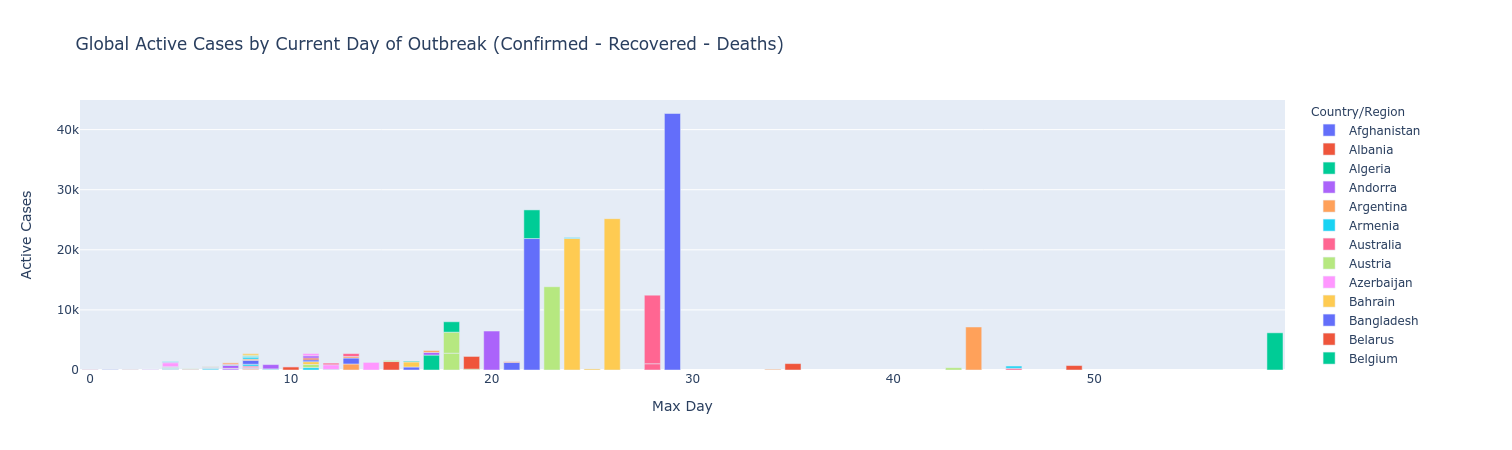

In [10]:
max_df = covid_19_infected_observations.groupby(['Country/Region', 'Max Day']).last().reset_index()
world_chart = px.bar(max_df, 
    x="Max Day", y="Active Cases", color="Country/Region", title="Global Active Cases by Current Day of Outbreak (Confirmed - Recovered - Deaths)")
world_chart.show()

In [11]:
cn_df = covid_19_national_observations.copy()
cn_df = cn_df[cn_df['Country/Region'] == 'China']

In [12]:
cn_df['Death'].max() / (cn_df['Active Cases'].max() * 1.14) 

0.04919756195058446

In [13]:
countries = covid_19_national_observations.groupby('Country/Region')

In [14]:
#select a single from group
#countries.get_group('China')

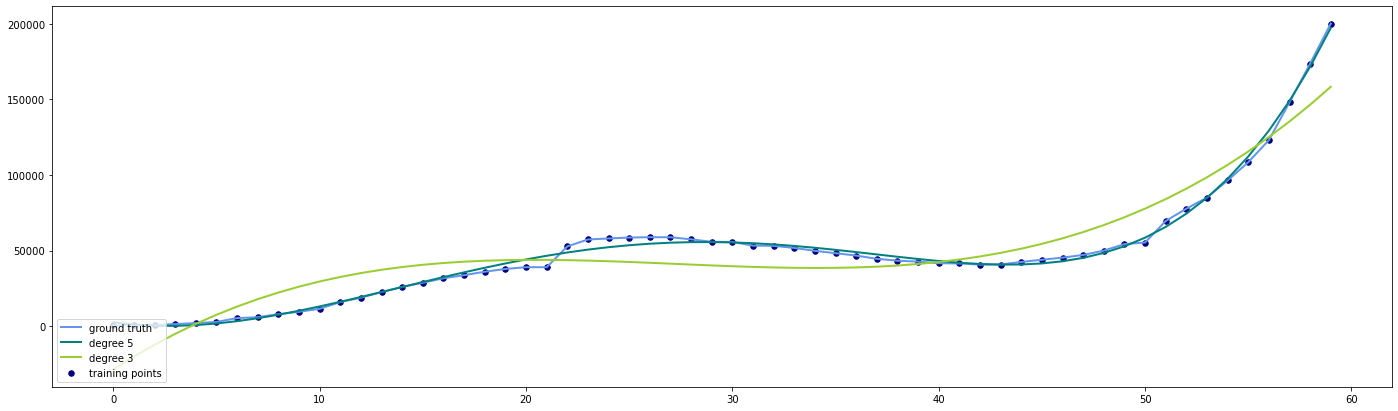

In [15]:
fDay=3

covid_19_world_totals=covid_19_world_totals.sort_values('Date')
covid_19_world_totals=covid_19_world_totals.reset_index(drop=True)
covid_19_world_totals['Day'] = covid_19_world_totals.index
x=covid_19_world_totals.index
y=covid_19_world_totals['Active Cases']

x_plot = x

# create matrix versions of these arrays
X = x[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

colors = ['teal', 'yellowgreen', 'gold']
lw = 2

plt.figure(figsize=(24,7))
plt.plot(x, y, color='cornflowerblue', linewidth=lw,
         label="ground truth")
plt.scatter(x, y, color='navy', s=30, marker='o', label="training points")

for count, degree in enumerate([5, 3]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(X, y)
    y_plot = model.predict(X_plot)
    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw,
             label="degree %d" % degree)

plt.legend(loc='lower left')

plt.show()

In [16]:
fb_df = covid_19_world_totals[['Date', 'Active Cases']].copy()
fb_df = fb_df.sort_values('Date').reset_index(drop=True)
fb_df.columns = ['ds','y']
#print(fb_df)

m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, growth='linear')
m.fit(fb_df)

future = m.make_future_dataframe(periods=5)

forecast = m.predict(future)

In [17]:
# uncomment to see the raw plot components
# fig2 = m.plot_components(forecast)

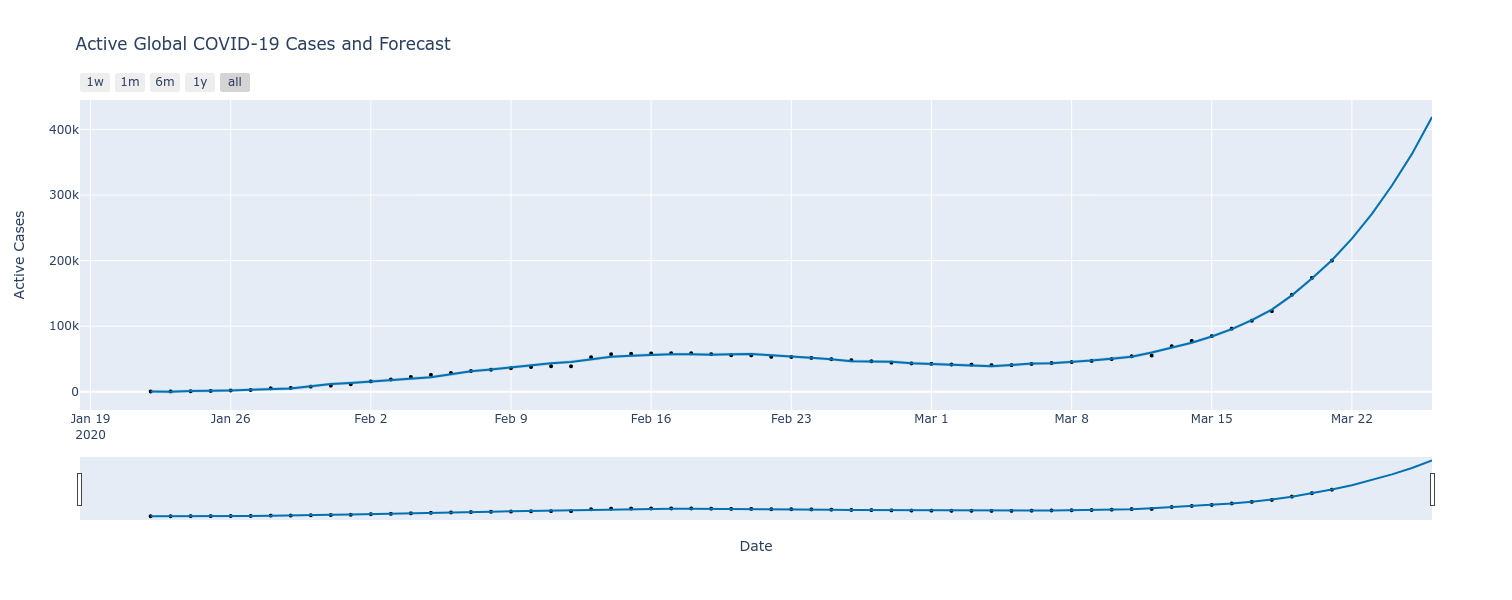

In [18]:
py.init_notebook_mode()

fig = plot_plotly(m, forecast, xlabel='Date', ylabel='Active Cases', uncertainty=True, figsize=(1200,600))  # This returns a plotly Figure
fig.update_layout(title='Active Global COVID-19 Cases and Forecast')
py.iplot(fig)

In [19]:
cluster_df = covid_19_infected_observations[['Day', 'Active Cases', 'Death', 'Recovered']]

cluster_df = MinMaxScaler().fit_transform(cluster_df)
db = DBSCAN(eps=0.01, min_samples=5).fit(cluster_df)
labels = db.labels_
covid_19_infected_observations['ClusterDB'] = labels

cluster_df = pd.DataFrame(cluster_df)
cluster_df.columns = ['Day', 'Active Cases', 'Death', 'Recovered']
covid_19_infected_observations['Active Score'] = cluster_df['Active Cases']
covid_19_infected_observations['Death Score'] = cluster_df['Death']

cluster_df_days = covid_19_infected_observations[['Day', 'Max Day', 'Active Cases', 'Death', 'Recovered']]

cluster_df_days = MinMaxScaler().fit_transform(cluster_df_days)
db = DBSCAN(eps=0.025, min_samples=3).fit(cluster_df_days)
labels = db.labels_
covid_19_infected_observations['ClusterDBDays'] = labels

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd60e6c4610>]],
      dtype=object)

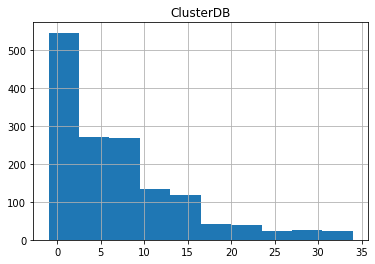

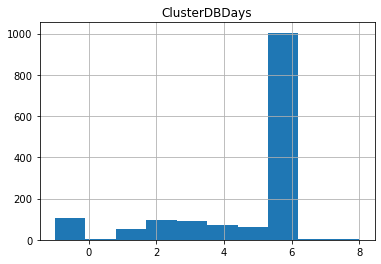

In [20]:
covid_19_infected_observations[['ClusterDB', 'Country/Region']].hist()
covid_19_infected_observations[['ClusterDBDays', 'Country/Region']].hist()

In [21]:
cluster_plot_df = covid_19_infected_observations[['Country/Region', 'ClusterDB', 'ClusterDBDays', 'Active Cases', 'Death', 'Max Day']].copy().groupby('Country/Region').mean().reset_index()

In [22]:
# show 3d cluster
# cluster_plot_3d = px.scatter_3d(cluster_plot_df, x = 'ClusterDB', y='ClusterDBDays', z='Active Cases', color='Country/Region')
# cluster_plot_3d.update_layout(
#     width=1200, height=700
# )
# cluster_plot_3d.show()

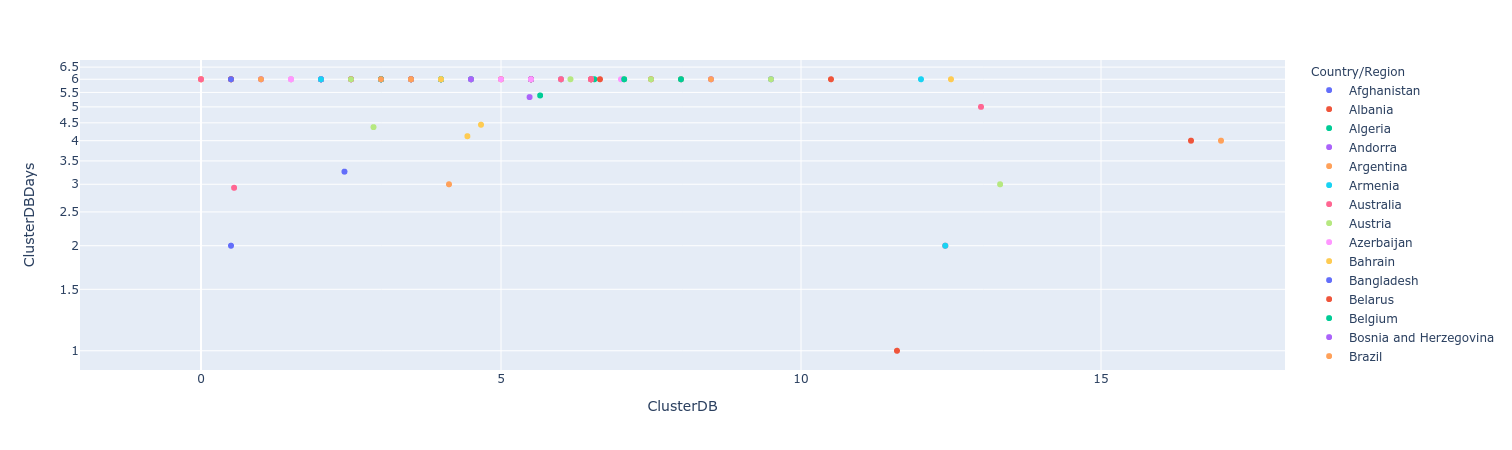

In [23]:
cluster_plot = px.scatter(cluster_plot_df, x = 'ClusterDB', y='ClusterDBDays', color='Country/Region',  log_y=True)
cluster_plot.show()

In [24]:
cluster_groups = covid_19_infected_observations.groupby(['ClusterDB'])

In [25]:
pd.set_option('display.max_rows', 500)
cluster_groups.head(500)

Date  Country/Region  Confirmed  Death  Recovered  Day  \
0    2020-01-22           China      548.0   17.0       28.0    0   
1    2020-01-23           China      643.0   18.0       30.0    1   
2    2020-01-24           China      920.0   26.0       36.0    2   
3    2020-01-25           China     1406.0   42.0       39.0    3   
4    2020-01-26           China     2075.0   56.0       49.0    4   
...         ...             ...        ...    ...        ...  ...   
1488 2020-03-21  United Kingdom     5067.0  234.0       67.0   22   
1489 2020-03-21         Uruguay      110.0    0.0        0.0    4   
1490 2020-03-21      Uzbekistan       43.0    0.0        0.0    2   
1491 2020-03-21       Venezuela       70.0    0.0        0.0    4   
1492 2020-03-21         Vietnam       94.0    0.0       17.0   13   

      Active Cases  Likely Cases 1pct  Likely Cases 1.8pct  \
0            503.0             1700.0               3060.0   
1            595.0             1800.0               3240.0   
2            858.0             2600.0               4680.0   
3           1325.0             4200.0               7560.0   
4           1970.0             5600.0              10080.0   
...            ...                ...                  ...   
1488        4766.0            23400.0              42120.0   
1489         110.0                0.0                  0.0   
1490          43.0                0.0                  0.0   
1491          70.0                0.0                  0.0   
1492          77.0                0.0                  0.0   

      Likely Cases 3.5pct  Death Rate  Death Change Rate  \
0                  5950.0       0.031                NaN   
1                  6300.0       0.028           0.058824   
2                  9100.0       0.028           0.444444   
3                 14700.0       0.030           0.615385   
4                 19600.0       0.027           0.333333   
...                   ...         ...                ...   
1488              81900.0       0.046           0.314607   
1489                  0.0       0.000                NaN   
1490                  0.0       0.000                NaN   
1491                  0.0       0.000                NaN   
1492                  0.0       0.000                NaN   

      Recovery Change Rate  Confirmed Change Rate          Case Bins  Max Day  \
0                      NaN                    NaN     (285.0, 651.8]       59   
1                 0.071429               0.173358     (285.0, 651.8]       59   
2                 0.200000               0.430793    (651.8, 2966.8]       59   
3                 0.083333               0.528261    (651.8, 2966.8]       59   
4                 0.256410               0.475818    (651.8, 2966.8]       59   
...                    ...                    ...                ...      ...   
1488              0.000000               0.262332  (2966.8, 58108.0]       22   
1489                   NaN               0.170213      (91.0, 155.0]        4   
1490                   NaN               0.303030       (31.0, 43.0]        2   
1491                   NaN               0.666667       (60.0, 91.0]        4   
1492              0.062500               0.032967       (60.0, 91.0]       13   

      ClusterDB  Active Score  Death Score  ClusterDBDays  
0             0      0.008588     0.003523              0  
1             1      0.010171     0.003731              0  
2            -1      0.014698     0.005389              0  
3            -1      0.022735     0.008705              0  
4            -1      0.033836     0.011606              0  
...         ...           ...          ...            ...  
1488         -1      0.081956     0.048497             -1  
1489          4      0.001824     0.000000              6  
1490          2      0.000671     0.000000              6  
1491          4      0.001136     0.000000              6  
1492         13      0.001256     0.000000              6  

[1493 rows x 20 column

In [26]:
# cluster_km = KMeans(n_clusters=3)
# cluster_km.fit(cluster_df)
# labels = cluster_km.labels_
# covid_19_infected_observations['ClusterK5'] = labels

In [27]:
# cluster_plot_df = covid_19_infected_observations[['Country/Region', 'ClusterK5', 'ClusterDB', 'Active Cases', 'Death']].copy().groupby('Country/Region').max().reset_index()
# cluster_plot_3d = px.scatter_3d(cluster_plot_df, x = 'ClusterK5', y='Active Cases', z='Death', color='Country/Region')
# #cluster_plot_3d.show()

In [28]:
# # let's show why kmeans/kmediods isn't sufficient for clustering this stuff
# cluster_plot = px.scatter(cluster_plot_df, x='ClusterK5', y='ClusterDB', color='Country/Region')
# cluster_plot.show()